In [1]:
# Problem Statement:
# Pick a double integrator. Implement a PD controller for it.
# Use imitation learning (Dagger) to learn the PD controller.
# Use RL to improve on the imitation learning when there are disturbances.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'serif' : 'Computer Modern Roman',
        'size'   : 16}
matplotlib.rc('font', **font)
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['figure.figsize'] = [2*3.54, 3.54]

from systems import AckermannVelDelay

In [3]:
# Util functions.
def wrap_circular_value(input_value):
    return (input_value + np.pi) % (2*np.pi) - np.pi

def clamp(input_value, min_value, max_value):
    if (input_value > max_value):
        return max_value
    if (input_value < min_value):
        return min_value
    return input_value

# Traj fcns.
def compute_fig8_simple(period, length, current_time, initial_state_I):
    t = current_time
    omega = 2 * np.pi / period
    x = length * np.sin(omega * t)
    y = length/2  * np.sin(2 * omega * t)
    z = 0.0
    vel_x = length * omega * np.cos(omega * t)
    vel_y = length * omega * np.cos(2 * omega * t)
    vel_z = 0.0

    fig_8_start_heading = initial_state_I[2] - np.pi/4
    R = np.array([[np.cos(fig_8_start_heading), -np.sin(fig_8_start_heading)],
                [np.sin(fig_8_start_heading), np.cos(fig_8_start_heading)]])
    x, y = R @ np.array([x, y]) + initial_state_I[0:2]
    vel_x, vel_y = R @ np.array([vel_x, vel_y])
    return x, y, z, vel_x, vel_y, vel_z


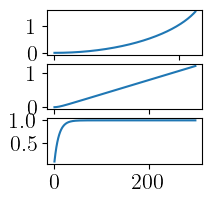

In [4]:
dt = 0.01
N = 300

# Systems
system = AckermannVelDelay(dt)
system.state = np.zeros(4)
state_list = []
state_perturb_list = []

for i in range(N):
    action = np.array([1.0, 0.2])
    result = system.step(action)
    state_list.append(system.state)
    
fig, ax = plt.subplots(3, 1, figsize=(2, 2))
state_list = np.array(state_list)
ax[0].plot(state_list[:, 0], state_list[:, 1], '-')
ax[1].plot(state_list[:, 2], '-', label='theta')    
ax[2].plot(state_list[:, 3], '-', label='v_x')    


In [5]:
# Expert Policies
class ExpertPolicy:
    def __init__(self, dt):
        self.integral_term = 0
        self.dt = dt
        self.kpx = 0.4
        self.kpy = 0.4
        self.ktheta = 1.0

        self.k_vel = 1.0
        self.K_PD = np.array([0.3, 0.11])
        self.max_steering_angle_deg = 30.0
        
    def __call__(self, x_I, theta, vel_I, omega, x_traj_I, vel_traj_I):
        # PD Controller:
        
        TRAJ_IDX_POS_X = 0
        TRAJ_IDX_HEADING = 2
    
        pos_des_I = x_traj_I[TRAJ_IDX_POS_X:TRAJ_IDX_HEADING]
        theta_des = wrap_circular_value(x_traj_I[TRAJ_IDX_HEADING])
        R_des = np.array([[np.cos(theta_des), -np.sin(theta_des)],
                            [np.sin(theta_des), np.cos(theta_des)]])
        
        v_des_I = vel_traj_I[TRAJ_IDX_POS_X:TRAJ_IDX_HEADING]
        v_des_B = R_des.T @ v_des_I
        omega_des = vel_traj_I[TRAJ_IDX_HEADING]

        # State.
        pos_I = x_I.copy()
        theta = wrap_circular_value(theta)
        R = np.array([[np.cos(theta), -np.sin(theta)],
                        [np.sin(theta), np.cos(theta)]])
        vel_B = R.T @ vel_I
        
        # Reference Trajectories.
        pos_error_I = pos_I - pos_des_I
        pos_error_B = R.T @ pos_error_I        
        pos_error_Bdes = R_des.T @ pos_error_I
        
        # Inputs: pos_error_B (2x1), pos_error_Bdes (2x1), vel_B (2x1),  theta, theta_des, v_des_B(2x1), omega, omega_des
        
        v_r = np.zeros(2)
        v_r[0] = v_des_B[0] - self.kpx * clamp(pos_error_Bdes[0], -0.5, 0.5)
        v_r[1] = v_des_B[1] - self.kpy * clamp(pos_error_Bdes[1], -0.5, 0.5)
        R_BdestoB = R.T @ R_des
        v_rB = R_BdestoB @ v_r

        if v_des_B[0] > 0.0:
            theta_ref = np.arctan2(v_r[1], v_r[0]) + theta_des
        else:
            theta_ref = np.arctan2(-v_r[1], -v_r[0]) + theta_des
        omega_ref = omega_des - clamp(self.ktheta * wrap_circular_value(theta - theta_ref), -1.2, 1.2)
        
        # Steering control.
        # x_dot = Ax + Bu (x = state linearized around desired traj)
        v_y_error = clamp(vel_B[1] - v_rB[1], -1.0, 1.0)
        omega_z_error = omega - omega_ref

        x_error_vec = np.array([v_y_error, omega_z_error])

        u_steering = - self.K_PD.T @ x_error_vec
        u_steering = clamp(u_steering, -np.deg2rad(self.max_steering_angle_deg), np.deg2rad(self.max_steering_angle_deg))
        
        # Vel control.
        ff_vel_traj = v_des_B[0]
        u_v = - self.k_vel * pos_error_B[0] + ff_vel_traj

        u = np.array([u_v, u_steering])
        return u

    
    

# Test the expert controller

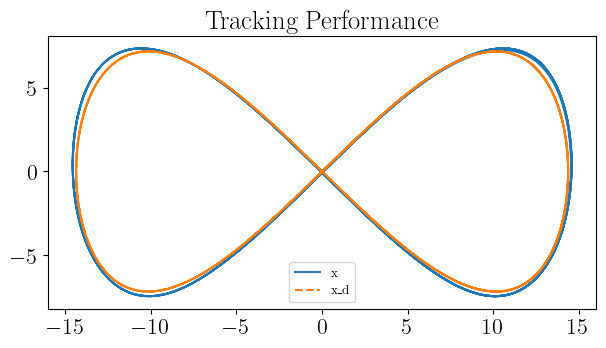

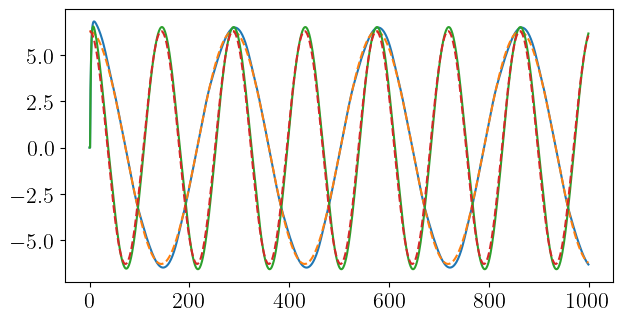

In [6]:
dt = 0.05
N = 1000

# Indices
TRAJ_IDX_POS_X = 0
TRAJ_IDX_POS_Y = 1
TRAJ_IDX_HEADING = 2

STATE_IDX_POS_X = 0
STATE_IDX_POS_Y = 1
STATE_IDX_HEADING = 2

system = AckermannVelDelay(dt)
system.state = np.zeros(4)
system.state[STATE_IDX_HEADING] = np.pi/4

period = np.random.uniform(10, 30)
length = period

xs = np.zeros((N, 3))
vels = np.zeros((N, 3))

t = np.arange(0, N*dt, dt)
theta_des_prev = 0.0
x0 = np.array([0.0, 0.0, np.pi/4])
for i, tt in enumerate(t):
    x = compute_fig8_simple(period, length, tt, x0)
    x, y, z, vx, vy, vz = x
    xs[i, TRAJ_IDX_POS_X] = x
    xs[i, TRAJ_IDX_POS_Y] = y
    theta_des = wrap_circular_value(np.arctan2(vy, vx))
    xs[i, TRAJ_IDX_HEADING] = theta_des
    vels[i, TRAJ_IDX_POS_X] = vx
    vels[i, TRAJ_IDX_POS_Y] = vy
    vels[i, TRAJ_IDX_HEADING] = wrap_circular_value((theta_des - theta_des_prev))/dt
    theta_des_prev = theta_des

state_list = []
vel_list = []
vel_des_list = []
des_traj_list = []
expert_policy = ExpertPolicy(dt)
x_I_prev = np.zeros(2)
theta_prev = 0
for i in range(N):
    x_I = system.state[STATE_IDX_POS_X:STATE_IDX_HEADING]
    theta = system.state[STATE_IDX_HEADING]
    theta = wrap_circular_value(theta)
    vel_I = (x_I - x_I_prev)/dt
    vel_list.append(vel_I)
    vel_des_list.append(vels[i])
    omega = wrap_circular_value(theta - theta_prev)/dt

    policy = expert_policy(x_I, theta, vel_I, omega, xs[i], vels[i])
    result = system.step(policy)

    x_I_prev = x_I.copy()
    theta_prev = theta.copy()

    state_list.append(system.state)
    des_traj_list.append(xs[i])
    
    
state_list = np.array(state_list)
des_traj_list = np.array(des_traj_list)
vel_list = np.array(vel_list)
vel_des_list = np.array(vel_des_list)

fig, ax = plt.subplots(1, 1)
ax.set_title('Tracking Performance')
ax.plot(state_list[:, 0], state_list[:, 1], '-', label='x')
ax.plot(des_traj_list[:, 0], des_traj_list[:, 1], '--', label='x_d')
ax.legend(fontsize='xx-small')

fig, ax = plt.subplots(1, 1)
ax.plot(vel_list[:, 0], '-', label='velx')
ax.plot(vel_des_list[:, 0], '--', label='velx_d')

ax.plot(vel_list[:, 1], '-', label='vely')
ax.plot(vel_des_list[:, 1], '--', label='vely_d')


# ax[1].plot(state_list[:, 1], '-', label='\dot{x}')
# ax[1].plot(des_traj_list[:, 1], '--', label='\dot{x}_d')


In [7]:
# # Multiple traj regulation:
# def multiple_traj_reg(sys, sys_name, policy):
#     nb_traj = 2
#     fig, ax = plt.subplots(2, 1, figsize=(2, 2), sharex=True)
#     for i in range(nb_traj):
#         sys.reset()
#         state_list = []
#         frequency = np.random.uniform(0.01, 0.05)
#         def get_N_pt_traj(N, frequency):
#             des_traj_pos = lambda t: np.cos(t*frequency)
#             pos_des = [des_traj_pos(i) for i in range(N)]
#             des_traj_vel = np.zeros(N)

#             for i in range(N - 1):
#                 des_traj_vel[i] = (pos_des[i+1] - pos_des[i])/dt
#             return pos_des, des_traj_vel

#         des_traj_pos, des_traj_vel = get_N_pt_traj(N, frequency)

#         sys.state = np.array([des_traj_pos[0], des_traj_vel[0]])
#         for i in range(N):
#             state_des = np.array([ des_traj_pos[i], des_traj_vel[i] ])
#             action = policy(sys.state, state_des)
#             if type(action) is not np.float64:
#                 action = action.detach().numpy()
#             result = sys.step(action.squeeze())
#             state_list.append(sys.state)
            
#         state_list = np.array(state_list)
#         ax[0].plot(state_list[:, 0], '-', label='x')
#         ax[0].plot(des_traj_pos, '--', label='x_d')
#         ax[1].plot(state_list[:, 1], '-', label='\dot{x}')    
#         ax[1].plot(des_traj_vel, '--', label='\dot{x}_d')
#         ax[0].set_title(sys_name, fontsize='xx-small')

# multiple_traj_reg(system, sys_name = 'Double Integrator', policy=expert_policy)
# multiple_traj_reg(system_perturbed, sys_name = 'Double Integrator with Perturbations', policy=expert_policy)
# multiple_traj_reg(system_perturbed, sys_name = 'Double Integrator with Perturbations', policy=expert_policy_nonlinear)
    

# Train Dagger

In [8]:
from nnpolicy import NNPolicy
from DAgger import DAgger


In [9]:
net_arch = [(12, 24), (24, 48), (48, 24), (24, 2)] # NN policy
policy = NNPolicy(net_arch)

In [10]:
epochs = 40
dagger_trainer = DAgger(system, expert_policy, policy, np.linspace(1, 0, epochs), 300, None, 1)

In [11]:
dagger_trainer.train_dagger(epochs)

Loss: 0.027072468772530556
[0.3765822649002075, 0.3184318542480469, 0.08345748484134674, 0.057935670018196106, 0.04257754981517792, 0.027072468772530556, 0.029396902769804, 0.030971232801675797, 0.036575835198163986, 0.04173607379198074, 0.04525147005915642, 0.04956308379769325, 0.052292726933956146, 0.05451657623052597, 0.05583539232611656, 0.056435976177453995, 0.05731503292918205, 0.05726292356848717, 0.05747804790735245, 0.058550987392663956, 0.0589410737156868, 0.059071704745292664, 0.059754807502031326, 0.060134775936603546, 0.06039566174149513, 0.060628268867731094, 0.06073247641324997, 0.06094536930322647, 0.061123721301555634, 0.06147696450352669]
Loss: 0.002626270055770874
[0.008116571232676506, 0.012400435283780098, 0.0031079791951924562, 0.00504780700430274, 0.003050755010917783, 0.003926022443920374, 0.0027655246667563915, 0.0029741907492280006, 0.002626270055770874, 0.0030906875617802143, 0.003151809563860297, 0.0035844226367771626, 0.003942413255572319, 0.004070765338838

In [12]:
# Evaluate

def policy_NN(x, x_des):
    input_NN = np.concatenate([x, x_des])
    return policy.predict(input_NN)

multiple_traj_reg(system, sys_name = 'Double Integrator', policy=policy_NN)
multiple_traj_reg(system_perturbed, sys_name = 'Double Integrator with Perturbations; Policy Dagger', policy=policy_NN)


NameError: name 'multiple_traj_reg' is not defined

In [ ]:
multiple_traj_reg(system_perturbed, sys_name = 'Double Integrator with Perturbations; Policy Dagger', policy=policy_NN)
